# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [40]:
# Load pickled data
import pickle
import matplotlib.pyplot as plt
import random
import pandas
import numpy as np
import cv2
import glob
import imgaug as ia
import tensorflow as tf
import os
import re
from imgaug import augmenters as iaa
from sklearn.utils import shuffle

training_file = "data/train.p"
validation_file = "data/valid.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Replace each question mark with the appropriate value.
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(train["features"])

# TODO: Number of validation examples
n_validation = len(valid["features"])

# TODO: Number of testing examples.
n_test = len(test["features"])

# TODO: What's the shape of an traffic sign image?
image_shape = train["features"][0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(list(set(train["labels"])))

print("Number of Validation examples =", n_validation)
print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of Validation examples = 4410
Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

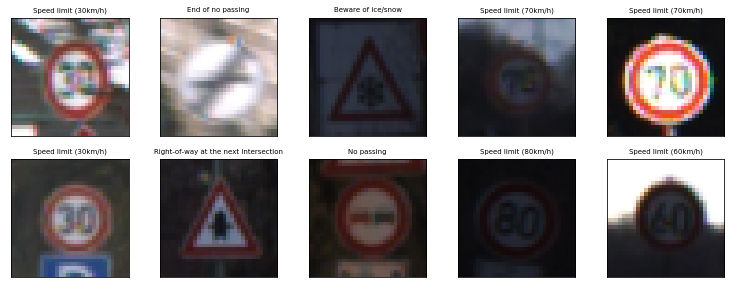

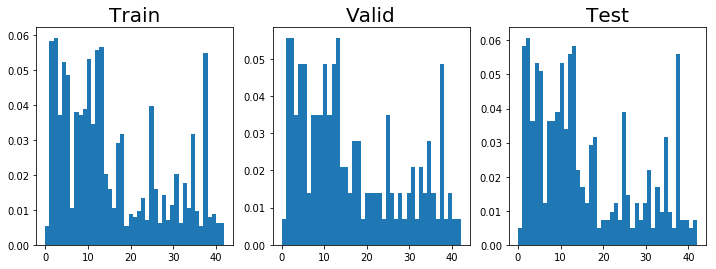

In [74]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
%matplotlib inline
def random_print(data, labels, random_size=10, labels_file="signnames.csv"):
    """
    Prints the image in a random way with the labels added
    
    Args:
        data: The Numpy array that contians the image files
        labels: The Numpy array that conatains the labels for the given image
        random_size: The size of the random images
        labels_file: The filename that contains the name of the labels
    """
    labels_text = pandas.read_csv(labels_file)
    # Visualizations will be shown in the notebook.
    list_r = random.sample(range(len(data)), random_size)
    fig, axs = plt.subplots(
        nrows=2,
        ncols=int(random_size / 2),
        figsize=(10, 9),
        subplot_kw={
            'xticks': [],
            'yticks': []
        })
    fig.subplots_adjust(left=0., right=1, top=0.9, bottom=0.5)
    for ax, i in zip(axs.flat, list_r):
        ax.imshow(data[i])
        ax.set_title(labels_text.at[labels[i], "SignName"], fontsize=7)


random_print(X_train, y_train)

# The distribution
labels = [y_train, y_valid, y_test]
titles = ['Train', 'Valid', 'Test']
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
for ax, label, title in zip(axes, labels, titles):
    ax.hist(label, n_classes, density=1)
    ax.set_title(title, fontsize=20)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

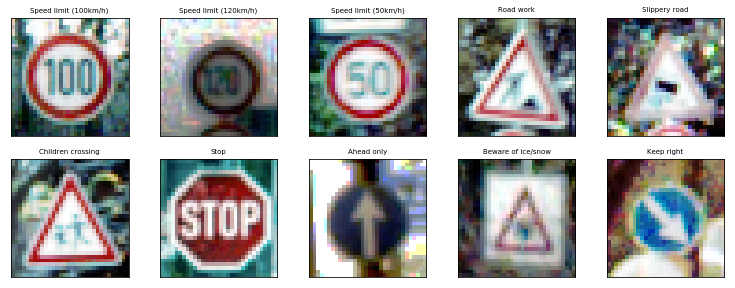

In [4]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.


def equalize_image(img):
    """
    Equalizes the given image with help of histogram
    
    Args:
        img: The array like image or PIL image
        
    Returns:
        img
    """
    img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
    img = img / 255.0 - 0.5
    return img


def normalize(data):
    """
    Normalizes the input data
    
    Args:
        data: The input data that contains the images
    """
    output = np.zeros(data.shape, np.float64)
    for i, img in enumerate(data):
        output[i] = equalize_image(img)
    return output


# Test the normalization
X_test_norm = normalize(X_test)
X_train_norm = normalize(X_train)
X_valid_norm = normalize(X_valid)

random_print(X_train_norm + 0.5, y_train)

In [6]:
## Image Agumentations, this helps to have most variants of the given image
## added to the training set.


def agument_images(data, labels):
    """
    Aguemnts the given data images and creates a bigger training set with
    the image agumentation.
    
    Args:
        data: The numpy array that contains the training images
        labels: The lables for the given image
    
    Returns:
        the complete set of data + agumented data
    """
    seq = iaa.Sequential(
        [
            #iaa.Fliplr(0.05), # horizontal flips
            #iaa.Crop(percent=(0, 0.1)), # random crops
            # Small gaussian blur with random sigma between 0 and 0.5.
            # But we only blur about 50% of all images.
            #iaa.Sometimes(0.5,
            #    iaa.GaussianBlur(sigma=(0, 0.5))
            #),
            # Strengthen or weaken the contrast in each image.
            #iaa.ContrastNormalization((0.75, 1.5)),
            # Add gaussian noise.
            # For 50% of all images, we sample the noise once per pixel.
            # For the other 50% of all images, we sample the noise per pixel AND
            # channel. This can change the color (not only brightness) of the
            # pixels.
            #iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
            # Make some images brighter and some darker.
            # In 20% of all cases, we sample the multiplier once per channel,
            # which can end up changing the color of the images.
            #iaa.Multiply((0.8, 1.2), per_channel=0.2),
            # Apply affine transformations to each image.
            # Scale/zoom them, translate/move them, rotate them and shear them.
            iaa.Affine(
                scale={
                    "x": (0.8, 1.2),
                    "y": (0.8, 1.2)
                },
                translate_percent={
                    "x": (-0.2, 0.2),
                    "y": (-0.2, 0.2)
                },
                rotate=(-10, 10),
                shear=(-10, 10))
        ],
        random_order=True)  # apply augmenters in random order
    final_data = np.copy(data)
    final_labels = np.copy(labels)
    for i in range(10):
        agumented_data = seq.augment_images(data)
        final_data = np.concatenate((final_data, agumented_data), axis=0)
        final_labels = np.concatenate((final_labels, labels), axis=0)
    return final_data, final_labels


final_train_data, final_labels = agument_images(X_train_norm, y_train)

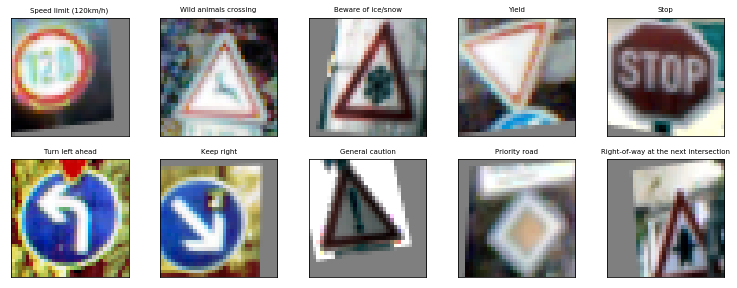

In [7]:
## Shuffle the images so, we have more randomness in the training sets
final_train_data, final_labels = shuffle(final_train_data, final_labels)
random_print(final_train_data + 0.5, final_labels)

### Model Architecture

In [8]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
EPOCHS = 16
BATCH_SIZE = 1024

In [133]:
### The LeNet is implemented here.


def LeNet(x, drop_out=False, mu=0, sigma=0.1):
    """
    The LeNet Neural Network Trainer, implemented using TensorFlow
    
    Args:
        x: The input and data placeholder for the trainign
        droup_out: If the LeNet should use drop outs
        mu: The hyperparameter that is used in tf.truncated_normal for randomizing weigths and biases
        sigma: The hyperparameter that is used in tf.truncated_normal for randomizing weigths and biases
    Returns:
        logits (Last layer results)
        regualizers (Sum all loss functions)
        All the convultion layers, so they can be used to have the view of what the layers are doing
    """
    # First layer
    ## Convultion -> 32x32x3 -> 32x32x12
    L0_conv_W = tf.Variable(
        tf.truncated_normal(shape=(5, 5, 3, 12), mean=mu, stddev=sigma))
    L0_conv_b = tf.Variable(tf.zeros(12))
    L0_conv = tf.nn.conv2d(
        x, L0_conv_W, strides=[1, 1, 1, 1], padding='SAME') + L0_conv_b

    # Second layer
    ## Convultion -> 32x32x12 -> 28x28x24 (Valid Padding omits 2 Pixel from each side)
    L1_conv_W = tf.Variable(
        tf.truncated_normal(shape=(5, 5, 12, 24), mean=mu, stddev=sigma))
    L1_conv_b = tf.Variable(tf.zeros(24))
    L1_conv = tf.nn.conv2d(
        L0_conv, L1_conv_W, strides=[1, 1, 1, 1], padding='VALID') + L1_conv_b

    # Third layer
    ## ReLU Activiation function
    L2_relu = tf.nn.relu(L1_conv)

    # Fourth layer
    ## MaxPool -> 28x28x24 -> 14x14x24
    L3_maxPool = tf.nn.max_pool(
        L2_relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Fifth layer
    ## Convultion 14x14x24 -> 14x14x48
    L4_conv_W = tf.Variable(
        tf.truncated_normal(shape=(5, 5, 24, 48), mean=mu, stddev=sigma))
    L4_conv_b = tf.Variable(tf.zeros(48))
    L4_conv = tf.nn.conv2d(
        L3_maxPool, L4_conv_W, strides=[1, 1, 1, 1],
        padding='SAME') + L4_conv_b

    # Sixth layer
    ## Convultion 14x14x48 -> 10x10x96
    L5_conv_W = tf.Variable(
        tf.truncated_normal(shape=(5, 5, 48, 96), mean=mu, stddev=sigma))
    L5_conv_b = tf.Variable(tf.zeros(96))
    L5_conv = tf.nn.conv2d(
        L4_conv, L5_conv_W, strides=[1, 1, 1, 1], padding='VALID') + L5_conv_b

    # Seventh layer
    ## ReLU Activation function
    L6_relu = tf.nn.relu(L5_conv)

    # Eighth layer
    ## MaxPool -> 10x10x96 -> 5x5x96
    L7_maxPool = tf.nn.max_pool(
        L6_relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Ninth layer
    ## Flatten 5x5x96 -> 2400
    L8_flat = tf.contrib.layers.flatten(L7_maxPool)

    # Tenth layer
    ## Fully connected (Not convulted :D) 2400 -> 480
    L9_conn_W = tf.Variable(
        tf.truncated_normal(shape=(2400, 480), mean=mu, stddev=sigma))
    L9_conn_b = tf.Variable(tf.zeros(480))
    L9_conn = tf.matmul(L8_flat, L9_conn_W) + L9_conn_b

    # Eleventh layer
    ## ReLU Activation
    L10_relu = tf.nn.relu(L9_conn)

    ## Drop-out
    if drop_out:
        L10_relu = tf.nn.dropout(L10_relu, keep_prob)

    # Twelfth layer
    ## Fully connected 480->84
    L11_conn_W = tf.Variable(
        tf.truncated_normal(shape=(480, 84), mean=mu, stddev=sigma))
    L11_conn_b = tf.Variable(tf.zeros(84))
    L11_conn = tf.matmul(L10_relu, L11_conn_W) + L11_conn_b

    # Thirteenth layer
    ## ReLU Activation
    L12_relu = tf.nn.relu(L11_conn)

    ## Drop-out
    if drop_out:
        L12_relu = tf.nn.dropout(L12_relu, keep_prob)

    # Fourteenth layer
    ## Fully connected 84 -> n_classes (43)
    L13_conn_W = tf.Variable(
        tf.truncated_normal(shape=(84, n_classes), mean=mu, stddev=sigma))
    L13_conn_b = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(L12_relu, L13_conn_W) + L13_conn_b

    # make the nn manipulate the network with the weigths
    regularizers = tf.nn.l2_loss(L0_conv_W) + tf.nn.l2_loss(L1_conv_W) + tf.nn.l2_loss(L4_conv_W) + \
            tf.nn.l2_loss(L5_conv_W) + tf.nn.l2_loss(L9_conn_W) +\
            tf.nn.l2_loss(L11_conn_W) + tf.nn.l2_loss(L13_conn_W)

    return logits, regularizers, L0_conv, L1_conv, L4_conv, L5_conv, L9_conn, L11_conn, L13_conn

In [10]:
keep_prob = tf.placeholder(tf.float32)
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [11]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected,
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.
l_rate = 0.0009
logits, regularizers, L0_conv, L1_conv, L4_conv, L5_conv, L9_conn, L11_conn = LeNet(
    x, True)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(
    labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy) + 1e-5 * regularizers
optimizer = tf.train.AdamOptimizer(learning_rate=l_rate)
training_operation = optimizer.minimize(loss_operation)

model_predictions = tf.argmax(logits, 1)
correct_predictions = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_calc = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
saver = tf.train.Saver()

In [12]:
## Caclulate the accuracy
def evaluate_accuracy(data, labels):
    """
    Evaulates the accuracy of the given training epoch
    
    Args:
        data: The data array that contains the images
        labels: The array that contains the label for the images
        
    Returns:
        The accuracy in a number between 0-1
    """
    num_examples = len(data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        data_batch, label_batch = data[offset:offset+BATCH_SIZE], labels[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_calc, feed_dict={x: data_batch, y: label_batch, keep_prob:1.0})
        total_accuracy += (accuracy * len(data_batch))
    return total_accuracy / num_examples

We are in Epoch 1 ...
The training Loss is = 1.5088
The training accuracy is = 0.5638
The validation accuracy is = 0.5821
The test acuracy is = 0.6032
We are in Epoch 2 ...
The training Loss is = 0.6359
The training accuracy is = 0.8913
The validation accuracy is = 0.9184
The test acuracy is = 0.9043
We are in Epoch 3 ...
The training Loss is = 0.3141
The training accuracy is = 0.9625
The validation accuracy is = 0.9653
The test acuracy is = 0.9473
We are in Epoch 4 ...
The training Loss is = 0.2483
The training accuracy is = 0.9793
The validation accuracy is = 0.9812
The test acuracy is = 0.9582
We are in Epoch 5 ...
The training Loss is = 0.1703
The training accuracy is = 0.9879
The validation accuracy is = 0.9868
The test acuracy is = 0.9647
We are in Epoch 6 ...
The training Loss is = 0.1389
The training accuracy is = 0.9909
The validation accuracy is = 0.9787
The test acuracy is = 0.9667
We are in Epoch 7 ...
The training Loss is = 0.1120
The training accuracy is = 0.9939
The vali

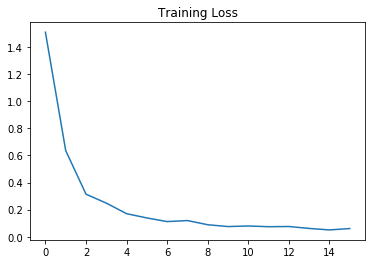

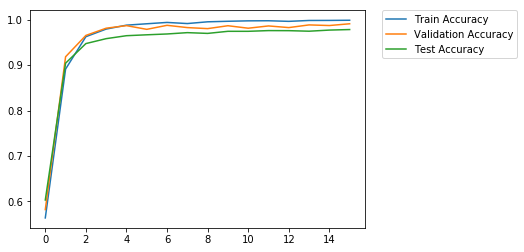

In [13]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    num = len(final_labels)

    train_losses = []
    train_acc = []
    valid_acc = []
    test_acc = []

    for j in range(EPOCHS):
        final_train_data, final_labels = shuffle(final_train_data,
                                                 final_labels)
        for i in range(0, num, BATCH_SIZE):
            start = i
            end = i + BATCH_SIZE
            data_batch, label_batch = final_train_data[
                start:end], final_labels[start:end]
            session.run([training_operation, loss_operation],
                        feed_dict={
                            x: data_batch,
                            y: label_batch,
                            keep_prob: 0.5
                        })
            train_loss = session.run(
                loss_operation,
                feed_dict={
                    x: data_batch,
                    y: label_batch,
                    keep_prob: 0.5
                })

        train_losses.append(train_loss)
        train_single_acc = evaluate_accuracy(final_train_data, final_labels)
        train_acc.append(train_single_acc)
        valid_single_acc = evaluate_accuracy(X_valid_norm, y_valid)
        valid_acc.append(valid_single_acc)
        test_single_acc = evaluate_accuracy(X_test_norm, y_test)
        test_acc.append(test_single_acc)

        print("We are in Epoch {} ...".format(j + 1))
        print("The training Loss is = {:.4f}".format(train_loss))
        print("The training accuracy is = {:.4f}".format(train_single_acc))
        print("The validation accuracy is = {:.4f}".format(valid_single_acc))
        print("The test acuracy is = {:.4f}".format(test_single_acc))

    saver.save(session, './lenet_me')
    print("Model saved")

    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.figure()

    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(valid_acc, label='Validation Accuracy')
    plt.plot(test_acc, label='Test Accuracy')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

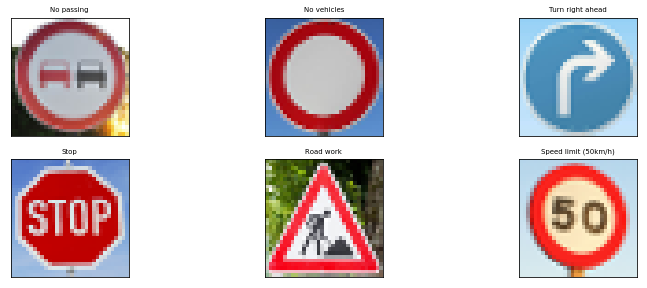

In [106]:
# Load and show the images found in internet

labels_text = pandas.read_csv('signnames.csv')
test_images = []
test_labels = np.array([14, 15, 25, 2, 33, 9])
for img in sorted(glob.glob("./test_images/*_small.png")):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    test_images.append(image)

random_print(test_images, test_labels, 6)

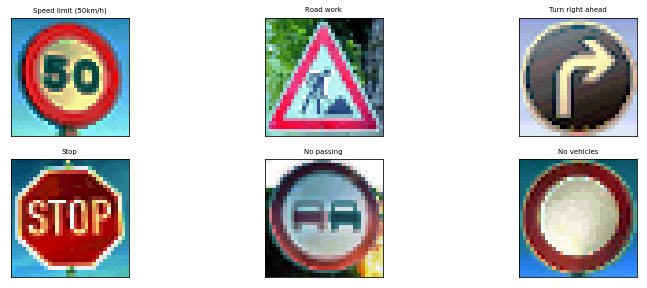

In [108]:
# Normalized images
normalized_test_images = normalize( np.asarray(test_images))
random_print(normalized_test_images+.5, test_labels, 6)

### Predict the Sign Type for Each Image

INFO:tensorflow:Restoring parameters from ./lenet_me
[14 15 25  5 33 40]


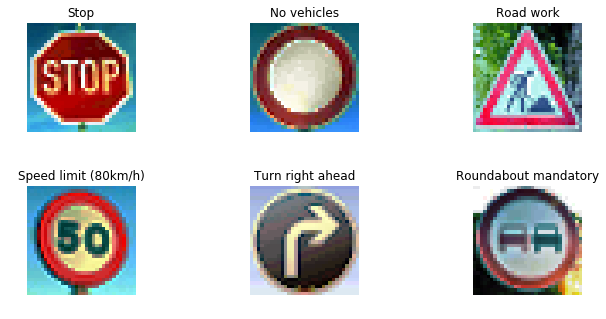

In [112]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./lenet_me.meta')
    saver.restore(sess, "./lenet_me")
    pred = sess.run(model_predictions, feed_dict = {x:normalized_test_images,y:test_labels,keep_prob:1.0})
    print(pred)
    fig, axs = plt.subplots(2,3, figsize=(10, 5),gridspec_kw={'wspace':1,'hspace':0.5})
    axs = axs.ravel()
    i=0
    for ax in axs.flat:
        ax.imshow(normalized_test_images[i]+.5)
        ax.axis('off')
        ax.set_title(class_names['SignName'][pred[i]])
        i = i+1   
    plt.show()

### Analyze Performance

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

INFO:tensorflow:Restoring parameters from ./lenet_me


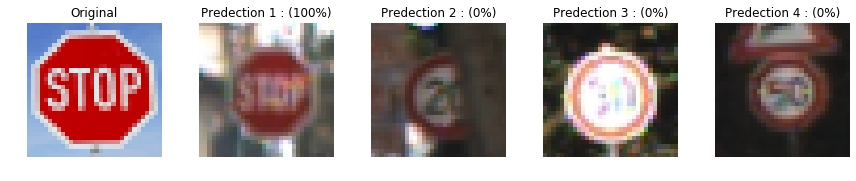

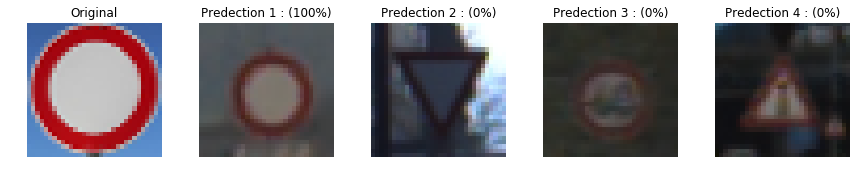

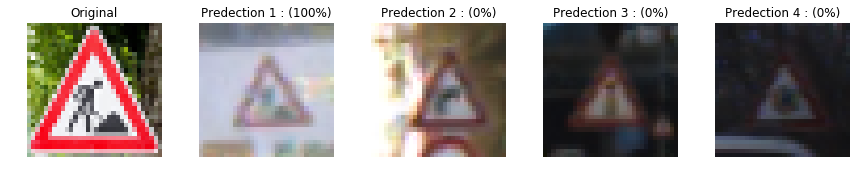

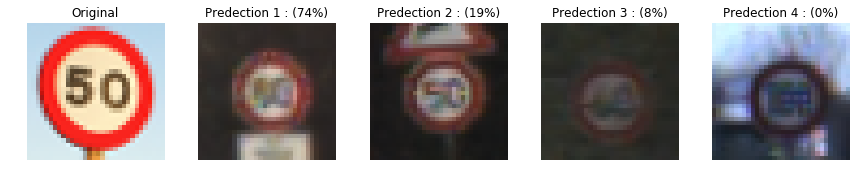

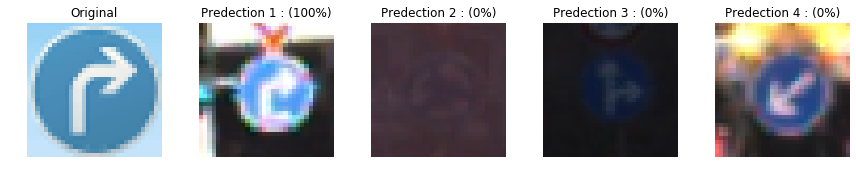

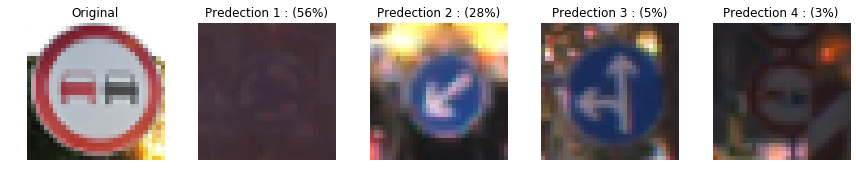

In [148]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
def plot_figures(figures, nrows = 1, ncols=1, labels=None):
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12, 14))
    axs = axs.ravel()
    for index, title in zip(range(len(figures)), figures):
        axs[index].imshow(figures[title], plt.gray())
        if(labels != None):
            axs[index].set_title(labels[index])
        else:
            axs[index].set_title(title)
        axs[index].set_axis_off()
    plt.tight_layout()

k_size = 4
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=k_size)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    my_saver = tf.train.import_meta_graph('./lenet_me.meta')
    saver.restore(sess, "./lenet_me")
    my_softmax_logits = sess.run(softmax_logits, feed_dict={x: normalized_test_images, keep_prob: 1.0})
    my_top_k = sess.run(top_k, feed_dict={x: normalized_test_images, keep_prob: 1.0})
    for i in range(6):
        figures = {}
        labels = {}
        figures[0] = test_images[i]
        labels[0] = "Original"
        for j in range(k_size):
            labels[j+1] = 'Predection {} : ({:.0f}%)'.format(j+1, 100 * my_top_k[0][i][j])
            figures[j+1] = X_valid[np.argwhere(y_valid == my_top_k[1][i][j])[0]].squeeze()
        plot_figures(figures, 1, 5, labels)

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [138]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,10, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

INFO:tensorflow:Restoring parameters from ./lenet_me


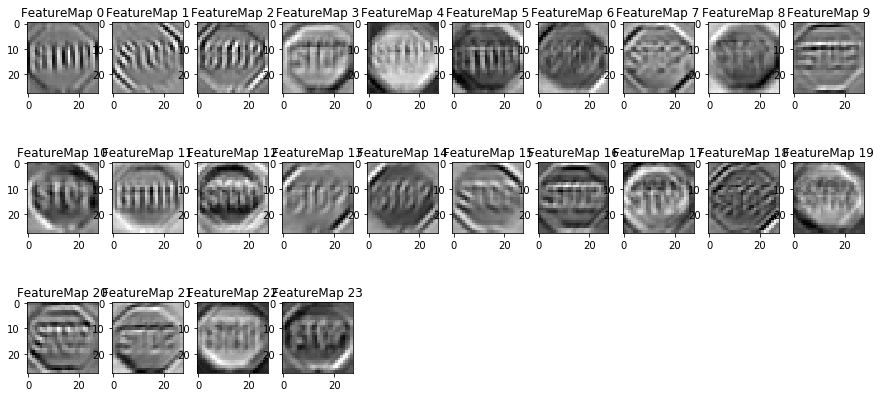

In [145]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    my_saver = tf.train.import_meta_graph('./lenet_me.meta')
    saver.restore(sess, "./lenet_me")
    outputFeatureMap(normalized_test_images, L1_conv)